In [1]:
import sys
import sys

sys.path.append("../src")
import time

import mlflow
import pandas as pd
import yaml
import fasttext

from constants import TEXT_FEATURE
from fasttext_classifier.fasttext_evaluator import FastTextEvaluator
from fasttext_classifier.fasttext_preprocessor import FastTextPreprocessor
from fasttext_classifier.fasttext_trainer import FastTextTrainer
from fasttext_classifier.fasttext_wrapper import FastTextWrapper
from utils import get_root_path

In [2]:
config_path = "config/config_fasttext27.yaml"

preprocessor = FastTextPreprocessor()

df = pd.read_csv("../data/logs_analysis.csv", engine="pyarrow")

with open(get_root_path() / config_path, "r") as stream:
    config = yaml.safe_load(stream)
params = config["params"]
categorical_features = config["categorical_features"]
Y = config["Y"][0]
oversampling = config["oversampling"]

*** Preprocessing the database...



mc cp minio/projet-ape/mlflow-artifacts/6/4e5c4673cbbd412e91456b3443e8dabe/artifacts/default/artifacts/default.bin models/model.bin

In [3]:
model = fasttext.load_model("../models/model.bin")

In [4]:
k = 2
res = model.predict(df["libelleNettoye"].to_list(), k=k)
preds = {
    rank_pred: [
        (x[rank_pred].replace("__label__", ""), y[rank_pred]) for x, y in zip(res[0], res[1])
    ]
    for rank_pred in range(k)
}

level = 5
predicted_classes = {
    f"predictions_{level}_k{rank_pred+1}": [pred[0] for pred in preds[rank_pred]]
    for rank_pred in range(k)
}
probs_prediction = {
    f"probabilities_k{rank_pred+1}": [prob[1] for prob in preds[rank_pred]]
    for rank_pred in range(k)
}
liasseNb = df.index

preds_df = pd.DataFrame(predicted_classes)
preds_df.set_index(liasseNb, inplace=True)

proba_df = pd.DataFrame(probs_prediction)
proba_df.set_index(liasseNb, inplace=True)
res_df = pd.merge(preds_df, proba_df, left_index=True, right_index=True)
res_df["score"] = res_df.probabilities_k1 - res_df.probabilities_k2

In [9]:
new_df = pd.merge(df, res_df, left_index=True, right_index=True)
new_df[(new_df["sourceAppel"] == "WF") & (new_df["score_x"] > 0.9) & (new_df["score_y"] < 0.9)][
    [
        "libelleActivite",
        "libelleNettoye",
        "timestamp",
        "first_pred",
        "predictions_5_k1",
        "second_pred",
        "predictions_5_k2",
        "first_proba",
        "probabilities_k1",
        "second_proba",
        "probabilities_k2",
    ]
]

In [19]:
test = new_df[
    (new_df["sourceAppel"] == "WF") & (new_df["score_x"] > 0.9) & (new_df["score_y"] < 0.9)
][
    [
        "libelleActivite",
        "libelleNettoye",
        "timestamp",
        "first_pred",
        "predictions_5_k1",
        "second_pred",
        "predictions_5_k2",
        "first_proba",
        "probabilities_k1",
        "second_proba",
        "probabilities_k2",
    ]
]
test.to_csv("comparison_old_new_models.csv")

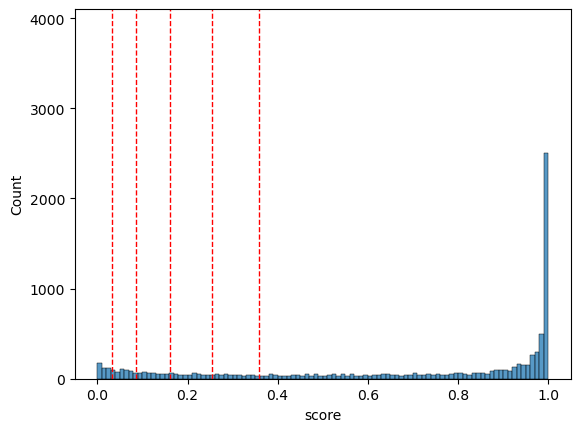

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram
sns.histplot(res_df.loc[:9084].score, binwidth=0.01)
plt.ylim(0, 4100)
plt.yticks(range(0, 4500, 1000))

# Calculate the quantiles
quantiles = res_df.loc[:9084].score.quantile([0.05, 0.1, 0.15, 0.2, 0.25])

# Add vertical lines at the quantiles
for q in quantiles:
    plt.axvline(q, color="r", linestyle="dashed", linewidth=1)

# Show the plot
plt.show()